## Описание данных: 
---
Процесс обработки проходит в три стадии: флотация, первый этап очистки, второй этап очистки. На всех этапах появляются отвальные хвосты. На выходе получается финальный концентрат, значение которого необходимо предсказать.  
Треин и тест выборки составлены из основных данных. 
Технологический процесс:  

-    `Rougher feed` — исходное сырье
-   `Rougher additions` (или `reagent additions`) флотационные реагенты: Xanthate, Sulphate, Depressant:
  -  `Xanthate **`— ксантогенат (промотер, или активатор флотации);
  -  `Sulphate` — сульфат (на данном производстве сульфид натрия);
  -  `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

Параметры этапов:  
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

Наименование признаков:
[этап].[тип_параметра].[название_параметра]
Возможные значения для блока [этап]:
-    `rougher` — флотация
-    `primary_cleaner` — первичная очистка
-    `secondary_cleaner` — вторичная очистка
-    `final` — финальные характеристики

Возможные значения для блока [тип_параметра]:
-    `input` — параметры сырья
-   `output` — параметры продукта
-    `state` — параметры, характеризующие текущее состояние этапа
-   `calculation` — расчётные характеристики


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy import stats as st
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

In [ ]:
pd.set_option('display.max_rows', 100)

## Подготовка данных

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/ml-2-gold_recovery_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/ml-2-gold_recovery_test.csv')
df = pd.read_csv('/content/drive/MyDrive/Data/ml-2-gold_recovery_full.csv')

In [ ]:
df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

In [ ]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

In [ ]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

На первый взгляд аномалий не обнаружено.

In [ ]:
train['date'].isin(df['date']).sum()

16860

In [ ]:
test['date'].isin(df['date']).sum()

5856

Проверяю, что тест и треин действительно части основного дф.

In [ ]:
sample = pd.DataFrame(df.head(1).T.head(100))

In [ ]:
sample = sample.reset_index()

In [ ]:
sample

,index,0
0,date,2016-01-15 00:00:00
1,final.output.concentrate_ag,6.0554
2,final.output.concentrate_pb,9.88965
3,final.output.concentrate_sol,5.50732
4,final.output.concentrate_au,42.192
5,final.output.recovery,70.5412
6,final.output.tail_ag,10.412
7,final.output.tail_pb,0.895447
8,final.output.tail_sol,16.9043
9,final.output.tail_au,2.14315


Вывожу пример техпроцесса одного куска руды для наглядности.

In [ ]:
train['rougher.output.recovery'].isna().sum()

2573

In [ ]:
train2 = train.dropna()

In [ ]:
train2.isna().sum()

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

In [ ]:
f = train2['rougher.input.feed_au']
c = train2['rougher.output.concentrate_au']
t = train2['rougher.output.tail_au']

In [ ]:
estimated_rougher_output_recovery = (c*(f-t))/(f*(c-t))*100

In [ ]:
estimated_rougher_output_recovery.isna().sum()

0

Для расчета ошибки создаю отдельный дф с удаленными пропусками. Для дальнейшей работы буду использовать изначальный.

In [ ]:
mean_absolute_error(train2['rougher.output.recovery'], estimated_rougher_output_recovery)

9.555596961987514e-15

Средняя абсолютная ошибка в пятнадцатом знаке, рекавери был посчитан правильно.

In [ ]:
test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [ ]:
train.columns[~train.columns.isin(test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

В тестовой выборке нет признаков, отвечающих за параметры продукта, получившегося после флотации/очистки и каких-то расчетов.

In [ ]:
train = train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'])

In [ ]:
train = train.fillna(method = 'ffill')

In [ ]:
test = test.fillna(method = 'ffill')

In [ ]:
df = df.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'])

In [ ]:
df = df.fillna(method = 'ffill')

Заполняю пропуски ближайшими значениями, так как по условиям задачи ближайшие события похожи.

## Анализ данных

In [ ]:
sample

,index,0
0,date,2016-01-15 00:00:00
1,final.output.concentrate_ag,6.0554
2,final.output.concentrate_pb,9.88965
3,final.output.concentrate_sol,5.50732
4,final.output.concentrate_au,42.192
5,final.output.recovery,70.5412
6,final.output.tail_ag,10.412
7,final.output.tail_pb,0.895447
8,final.output.tail_sol,16.9043
9,final.output.tail_au,2.14315


In [ ]:
result = []
for i in sample['index']:
    if 'concentrate_au' in i:
        result.append(i)
    elif 'concentrate_ag' in i:
        result.append(i)
    elif 'concentrate_pb' in i:
        result.append(i)
    elif 'feed_au' in i:
        result.append(i)
    elif 'feed_ag' in i:
        result.append(i)
    elif 'feed_pb' in i:
        result.append(i)
result

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

{'boxes': [<matplotlib.lines.Line2D at 0x7fea0157d790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea00a72810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fea00a7b850>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fea00a7b310>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fea0157dd50>,
  <matplotlib.lines.Line2D at 0x7fea00aaa4d0>]}

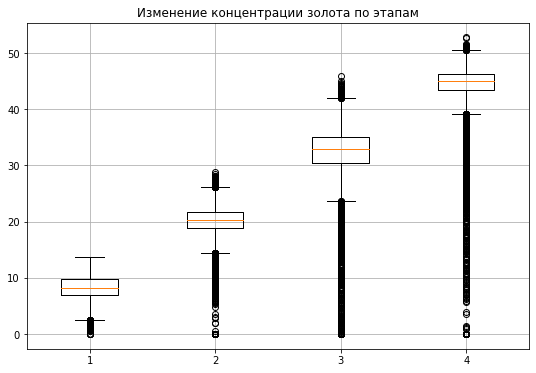

In [ ]:
plt.figure(figsize = (9,6))
plt.grid()
plt.title('Изменение концентрации золота по этапам')
plt.boxplot(x =[df['rougher.input.feed_au'],
                df['rougher.output.concentrate_au'],
                df['primary_cleaner.output.concentrate_au'],
                df['final.output.concentrate_au']])

Концентрация золота растет на каждом этапе. На четвертом этапе она более чем в четыре раза больше, чем на первом этапе.

{'boxes': [<matplotlib.lines.Line2D at 0x7fea0058de50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea00596e90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fea0059ced0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fea0059c990>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fea00596410>,
  <matplotlib.lines.Line2D at 0x7fea0054e9d0>]}

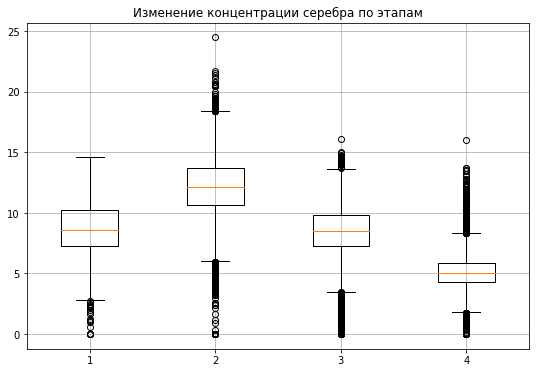

In [ ]:
plt.figure(figsize = (9,6))
plt.grid()
plt.title('Изменение концентрации серебра по этапам')
plt.boxplot(x =[df['rougher.input.feed_ag'],
                df['rougher.output.concentrate_ag'],
                df['primary_cleaner.output.concentrate_ag'],
                df['final.output.concentrate_ag']])

Концентрация серебра падает, на четвертом этапе она в полтора раза меньше, чем на первом.

{'boxes': [<matplotlib.lines.Line2D at 0x7fea004dae50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea00463e90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fea0046bed0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fea0046b990>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fea00463410>,
  <matplotlib.lines.Line2D at 0x7fea0049d9d0>]}

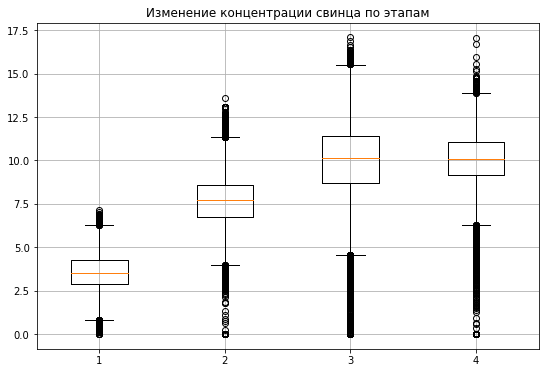

In [ ]:
plt.figure(figsize = (9,6))
plt.grid()
plt.title('Изменение концентрации свинца по этапам')
plt.boxplot(x =[df['rougher.input.feed_pb'],
                df['rougher.output.concentrate_pb'],
                df['primary_cleaner.output.concentrate_pb'],
                df['final.output.concentrate_pb']])

Концентрация свинца на втором и третьем этапах вырастает, потом практически не меняется.

In [ ]:
sample

,index,0
0,date,2016-01-15 00:00:00
1,final.output.concentrate_ag,6.0554
2,final.output.concentrate_pb,9.88965
3,final.output.concentrate_sol,5.50732
4,final.output.concentrate_au,42.192
5,final.output.recovery,70.5412
6,final.output.tail_ag,10.412
7,final.output.tail_pb,0.895447
8,final.output.tail_sol,16.9043
9,final.output.tail_au,2.14315


(<matplotlib.axes._subplots.AxesSubplot at 0x7fea00a66e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea00a66e10>)

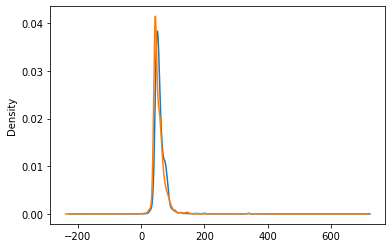

In [ ]:
train['rougher.input.feed_size'].plot.kde(), test['rougher.input.feed_size'].plot.kde()

In [ ]:
train['rougher.input.feed_size'].mean(), test['rougher.input.feed_size'].mean()

(60.23985599255735, 55.89886568885056)

Плотности распределений находятся более-менее в одном диапазоне, плюс средние близки.

In [ ]:
sample

,index,0
0,date,2016-01-15 00:00:00
1,final.output.concentrate_ag,6.0554
2,final.output.concentrate_pb,9.88965
3,final.output.concentrate_sol,5.50732
4,final.output.concentrate_au,42.192
5,final.output.recovery,70.5412
6,final.output.tail_ag,10.412
7,final.output.tail_pb,0.895447
8,final.output.tail_sol,16.9043
9,final.output.tail_au,2.14315


In [ ]:
for i in sample['index']:
    if 'concentrate_sol' in i:
        result.append(i)
    elif 'feed_sol' in i:
        result.append(i)
result.sort()

In [ ]:
result

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol']

Создаю выброку признаков концентрации для создания гистограмм.

In [ ]:
conc_final = (df['final.output.concentrate_ag'] +
              df['final.output.concentrate_au'] +
              df['final.output.concentrate_pb'] +
              df['final.output.concentrate_sol'])
conc_clean = (df['primary_cleaner.output.concentrate_ag'] +
              df['primary_cleaner.output.concentrate_au'] +
              df['primary_cleaner.output.concentrate_pb'] +
              df['primary_cleaner.output.concentrate_sol'])
conc_rough = (df['rougher.output.concentrate_ag'] +
              df['rougher.output.concentrate_au'] +
              df['rougher.output.concentrate_pb'] +
              df['rougher.output.concentrate_sol'])
conc_rough_inp = (df['rougher.input.feed_ag'] +
                  df['rougher.input.feed_au'] +
                  df['rougher.input.feed_pb'] +
                  df['rougher.input.feed_sol'])

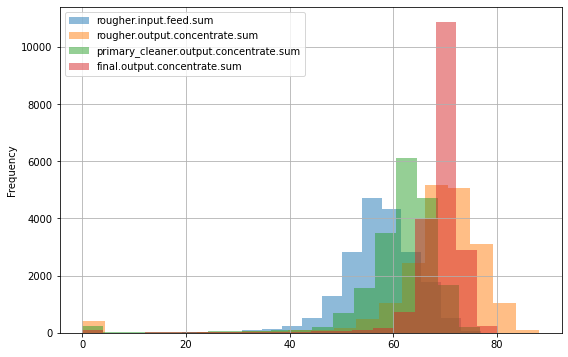

In [ ]:
plt.figure(figsize = (9,6))
conc_rough_inp.plot(kind = 'hist', label = 'rougher.input.feed.sum', alpha = 0.5, bins = 20)
conc_rough.plot(kind = 'hist', label = 'rougher.output.concentrate.sum', alpha = 0.5, bins = 20)
conc_clean.plot(kind = 'hist', label = 'primary_cleaner.output.concentrate.sum', alpha = 0.5, bins = 20)
conc_final.plot(kind = 'hist', label = 'final.output.concentrate.sum', alpha = 0.5, bins = 20)
plt.grid()
plt.legend()

Очень много нулевых или около нулевых значений, их стоит удалить, так как они ни о чем не говорят.

In [ ]:
df = df[df['rougher.input.feed_ag'] > 0.5]
df = df[df['rougher.input.feed_au'] > 0.5]
df = df[df['rougher.input.feed_pb'] > 0.5]
df = df[df['rougher.input.feed_sol'] > 0.5]
df = df[df['rougher.input.feed_size'] > 0.5]
df = df[df['rougher.output.concentrate_ag'] > 0.5]
df = df[df['rougher.output.concentrate_au'] > 0.5]
df = df[df['rougher.output.concentrate_pb'] > 0.5]
df = df[df['rougher.output.concentrate_sol'] > 0.5]
df = df[df['primary_cleaner.output.concentrate_ag'] > 0.5]
df = df[df['primary_cleaner.output.concentrate_au'] > 0.5]
df = df[df['primary_cleaner.output.concentrate_pb'] > 0.5]
df = df[df['primary_cleaner.output.concentrate_sol'] > 0.5]
df = df[df['final.output.concentrate_ag'] > 0.5]
df = df[df['final.output.concentrate_au'] > 0.5]
df = df[df['final.output.concentrate_pb'] > 0.5]
df = df[df['final.output.concentrate_sol'] > 0.5]

In [ ]:
test = test[test['date'].isin(df['date'])].copy()

In [ ]:
train = train[train['rougher.input.feed_ag'] > 0.5]
train = train[train['rougher.input.feed_au'] > 0.5]
train = train[train['rougher.input.feed_pb'] > 0.5]
train = train[train['rougher.input.feed_sol'] > 0.5]
train = train[train['rougher.input.feed_size'] > 0.5]
train = train[train['rougher.output.concentrate_ag'] > 1]
train = train[train['rougher.output.concentrate_au'] > 1]
train = train[train['rougher.output.concentrate_pb'] > 1]
train = train[train['rougher.output.concentrate_sol'] > 1]
train = train[train['primary_cleaner.output.concentrate_ag'] > 0.5]
train = train[train['primary_cleaner.output.concentrate_au'] > 0.5]
train = train[train['primary_cleaner.output.concentrate_pb'] > 0.5]
train = train[train['primary_cleaner.output.concentrate_sol'] > 0.5]
train = train[train['final.output.concentrate_ag'] > 0.5]
train = train[train['final.output.concentrate_au'] > 0.5]
train = train[train['final.output.concentrate_pb'] > 0.5]
train = train[train['final.output.concentrate_sol'] > 0.5]

In [ ]:
conc_final = (df['final.output.concentrate_ag'] +
              df['final.output.concentrate_au'] +
              df['final.output.concentrate_pb'] +
              df['final.output.concentrate_sol'])
conc_clean = (df['primary_cleaner.output.concentrate_ag'] +
              df['primary_cleaner.output.concentrate_au'] +
              df['primary_cleaner.output.concentrate_pb'] +
              df['primary_cleaner.output.concentrate_sol'])
conc_rough = (df['rougher.output.concentrate_ag'] +
              df['rougher.output.concentrate_au'] +
              df['rougher.output.concentrate_pb'] +
              df['rougher.output.concentrate_sol'])
conc_rough_inp = (df['rougher.input.feed_ag'] +
                  df['rougher.input.feed_au'] +
                  df['rougher.input.feed_pb'] +
                  df['rougher.input.feed_sol'])

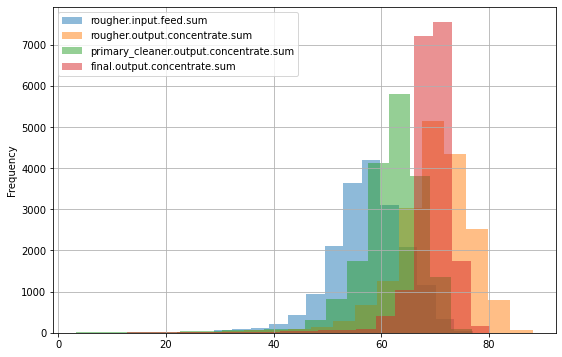

In [ ]:
plt.figure(figsize = (9,6))
conc_rough_inp.plot(kind = 'hist', label = 'rougher.input.feed.sum', alpha = 0.5, bins = 20)
conc_rough.plot(kind = 'hist', label = 'rougher.output.concentrate.sum', alpha = 0.5, bins = 20)
conc_clean.plot(kind = 'hist', label = 'primary_cleaner.output.concentrate.sum', alpha = 0.5, bins = 20)
conc_final.plot(kind = 'hist', label = 'final.output.concentrate.sum', alpha = 0.5, bins = 20)
plt.grid()
plt.legend()

## Модель

In [ ]:
def mini_smape(y_true, y_pred):
    res2 = []
    for i in range(len(y_true)):
        res = (abs(y_true[i] - y_pred[i]))/((abs(y_true[i])+abs(y_pred[i]))/2)
        res2.append(res)
    res3 = (sum(res2))/len(y_true)
    res3 = res3*100
    return res3

In [ ]:
def smape(y_true, y_pred):
    rougher = mini_smape(y_true.values[:,0], y_pred[:,0])
    final = mini_smape(y_true.values[:,1], y_pred[:,1])
    smape = (rougher*0.25) + (final*0.75)
    return smape

Функция расчета сМАПЕ, в соответствии с условиями задачи.

Нужно спрогнозировать две величины:
-    эффективность обогащения чернового концентрата rougher.output.recovery;
-    эффективность обогащения финального концентрата final.output.recovery.

In [ ]:
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)

In [ ]:
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
features_train = features_train.filter(items = test)

In [ ]:
q = df[['date', 'rougher.output.recovery', 'final.output.recovery']]

In [ ]:
test = test.merge(q, how = 'left', on = 'date')

In [ ]:
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)

In [ ]:
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
len(features_train) == len(target_train)

True

In [ ]:
len(features_test) == len(target_test)

True

Проверяю, что все сходится после преобразований.

In [ ]:
score = make_scorer(smape, greater_is_better = False)

Делаю сМАПЕ метрикой, чтобы использовать ее при гридсерче. При этом устанавливаю отрицательный знак для минимизации метрики.

In [ ]:
model = RandomForestRegressor(random_state = 4, n_jobs=-1)
grid = {'max_depth': range(10, 70),
        'n_estimators': range(10,100)}
random_search = RandomizedSearchCV(model, param_distributions = grid, n_iter = 20, random_state = 4, scoring = score,
                                   cv = 5, verbose = 1000)
random_search.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=76, max_depth=22 ...................................
[CV] ...... n_estimators=76, max_depth=22, score=-9.717, total=  35.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.5s remaining:    0.0s
[CV] n_estimators=76, max_depth=22 ...................................
[CV] ..... n_estimators=76, max_depth=22, score=-10.009, total=  34.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[CV] n_estimators=76, max_depth=22 ...................................
[CV] ...... n_estimators=76, max_depth=22, score=-8.667, total=  32.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[CV] n_estimators=76, max_depth=22 ...................................
[CV] ...... n_estimators=76, max_depth=22, score=-9.582, total=  33.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elaps

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [ ]:
random_search.cv_results_

{'mean_fit_time': array([33.68452573, 27.84631758, 30.90465474, 35.36916242, 37.30122409,
         6.00701871, 40.93664045,  5.37207913, 40.37529168, 41.96370287,
         8.08222327, 23.89958644, 16.61840744, 30.89507942, 32.06897445,
        19.11050782, 27.24835081, 32.69861193, 20.51022964,  7.14297919]),
 'mean_score_time': array([0.11508899, 0.1138207 , 0.11528931, 0.11381135, 0.11523194,
        0.11389818, 0.11387491, 0.11399651, 0.11392708, 0.11396284,
        0.11399984, 0.11531549, 0.11396151, 0.1137279 , 0.11402864,
        0.11396303, 0.11405134, 0.1141922 , 0.11370163, 0.1139987 ]),
 'mean_test_score': array([ -9.65057681,  -9.45518863,  -9.75083187,  -9.55549428,
         -9.6560449 , -10.38760294,  -9.56665897, -10.19858608,
         -9.55019881,  -9.58274272, -10.19050815,  -9.77245471,
        -10.08876623,  -9.75973482,  -9.75710067, -10.03981067,
         -9.66701796,  -9.69613859,  -9.69814226, -10.24488598]),
 'param_max_depth': masked_array(data=[22, 11, 37, 17, 

In [ ]:
random_search.best_params_

{'max_depth': 11, 'n_estimators': 94}

При переборе рандом серчем, с кросс-валидацией получено значение сМАПЕ 9,2%

In [ ]:
model = RandomForestRegressor(random_state = 4, n_estimators = 94, max_depth = 11)
final_score = cross_val_score(model, features_train, target_train, cv = 5, scoring = score)
abs(final_score.mean())

9.455188631936304

In [ ]:
model = LinearRegression()
final_score = cross_val_score(model, features_train, target_train, cv = 5, scoring = score)
abs(final_score.mean())

9.990170494558626

Выбран случайный лес, так как он показал значение sMAPE 9.4% на кросс-валидации при параметрах:
- n_estimators: 94;
- max_depth: 11;

In [ ]:
model = RandomForestRegressor(random_state = 4, n_estimators = 94, max_depth = 11)
model.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=11, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=94, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

In [ ]:
predictions = model.predict(features_test)

In [ ]:
smape(target_test, predictions)

7.816902498137103

На тестовой выборке получаю значение сМАПЕ 7.8%.

In [ ]:
train[['rougher.output.recovery', 'final.output.recovery']].mean()

rougher.output.recovery    84.572520
final.output.recovery      66.861601
dtype: float64

In [ ]:
target_test

,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5092,95.172585,68.919891
5093,94.575036,68.440582
5094,93.018138,67.092759
5095,92.599042,68.061186


## Вывод

В процессе исследования были выполнены следующие работы:

Подготовка и проверка данных

- данные проверены на наличие ошибок;
- выборки проверены на соответствие главной выборке;
- проверена правильность расчета рекавери, средняя абсолютная ошибка в минус пятнадцатой степени (расчет был произведен верно).

Анализ данных

Исследована концентрация металлов на всех этапах очистки, обнаружено, что:
- концентрация золота растет на каждом этапе. На четвертом этапе она более чем в четыре раза больше, чем на первом этапе;
- концентрация серебра падает, на четвертом этапе она в полтора раза меньше, чем на первом;
- концентрация свинца на втором и третьем этапах вырастает, потом практически не меняется.

Исследовано соответствие распределений размеров гранул сырья треин и тест выборок. Они находятся примерно в одном диапазоне, при этом средние значения этих выборок имеют разницу в 5.

Исследована суммарная концентрация всех веществ на всех этапах очистки. В целом распределения выглядят адекватно, однако приутствуют нулевые значения, которые были удалены из обучающей выборки.

Выбор и тестирование модели

Написана функция для расчета симметричного среднего абсолютного процентного отклонения (sMAPE), в соответствии с условиями задачи.

Выбраны модели:

LinearRegression, которая показала значение sMAPE - 9.9% при кросс-валидации.

RandomForestRegressior, которой случайным поиском были подобраны следующие параметры:
- n_estimators: 70;
- max_depth: 14;
при этом она показала значение sMAPE 9,4% при кросс-валидации.

С теми же параметрами на тестовой выборке значение sMAPE получилось равным 7.8%.